In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [531]:
from numpy.random import normal
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [6]:
temps = normal(22, 1, 1000)

(array([ 22.,  67., 102., 221., 226., 197., 114.,  33.,  14.,   4.]),
 array([19.34965351, 19.9524671 , 20.5552807 , 21.1580943 , 21.7609079 ,
        22.36372149, 22.96653509, 23.56934869, 24.17216228, 24.77497588,
        25.37778948]),
 <a list of 10 Patch objects>)

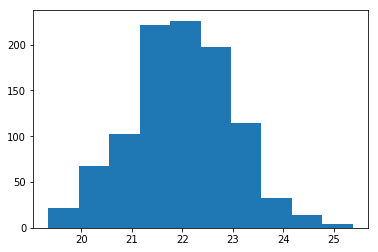

In [7]:
hist(temps)

In [16]:
from random import Random

In [17]:
rnd = Random()

In [18]:
rnd.normalvariate(0, 1)

0.6760006085671341

In [12]:
temps = [rnd.normalvariate(22, 0.5) for _ in range(1000)]

(array([  3.,  25.,  86., 162., 251., 245., 154.,  51.,  21.,   2.]),
 array([20.45294826, 20.77438649, 21.09582471, 21.41726294, 21.73870116,
        22.06013939, 22.38157761, 22.70301584, 23.02445406, 23.34589229,
        23.66733051]),
 <a list of 10 Patch objects>)

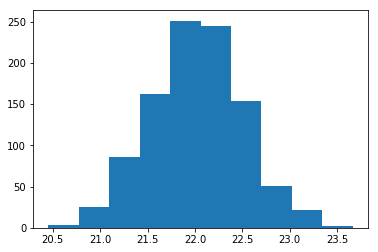

In [13]:
hist(temps)

In [89]:
P = array([[0, 1, 0],[1/6,2/3,1/6],[2/3,0,1/3]])

In [80]:
np.linalg.eig(P)[1][0]/sum(np.linalg.eig(P)[1][0])

array([0.40550952-0.j        , 0.29724524-0.21018412j,
       0.29724524+0.21018412j])

In [86]:
P = array([[0.6, 0.4, 0],[0.6,0.4,0.0],[0.5,0.5,0.0]])

In [3]:
def eiv(P):
    S, U = np.linalg.eig(P.T)
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    stationary = stationary / np.sum(stationary)
    return real(stationary) 

In [578]:
thermal_coefficent = lambda t: 4
temps = lambda t: [environment_temp(t) + thermal_coefficent(t)*q.T.dot(eiv(x)) for x in default_control]
omega = lambda t: [[np.abs(temps(t)[i] - temps(t)[j]) < 2 and temps(t)[i] > 17 and temps(t)[i]<26
                    for j in range(len(default_control))] for i in range(len(default_control))]

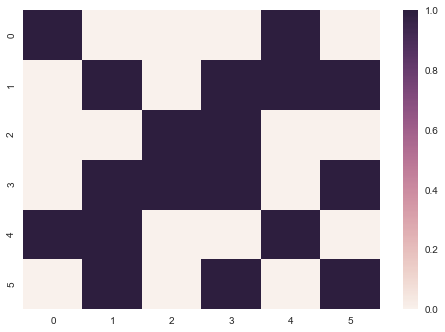

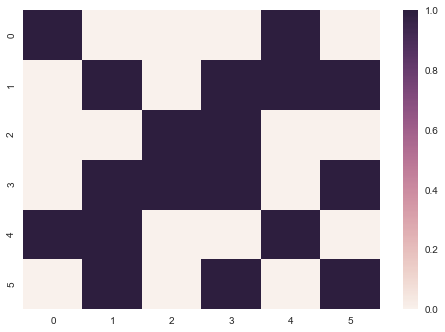

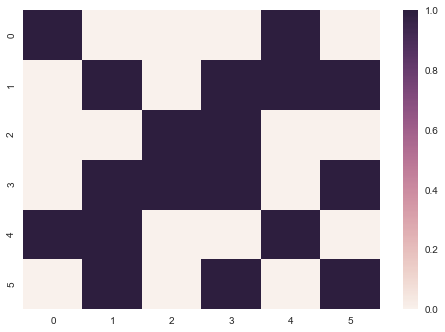

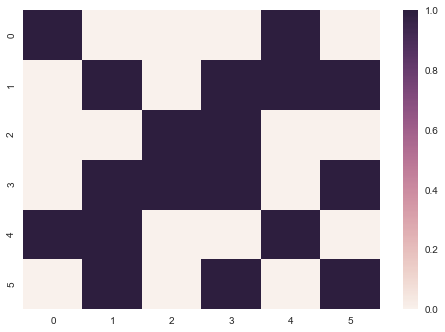

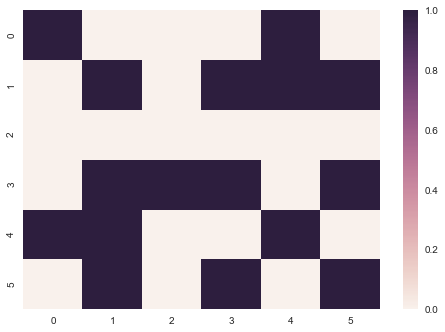

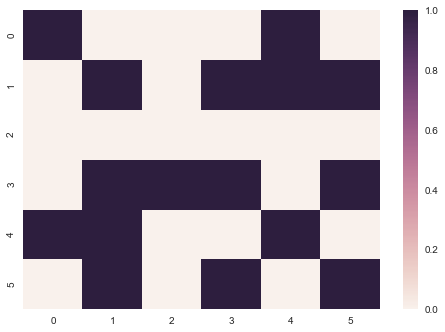

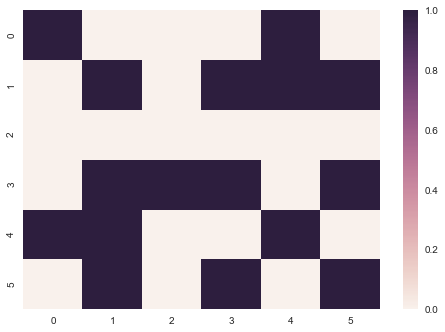

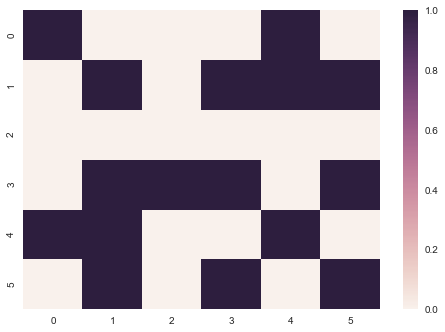

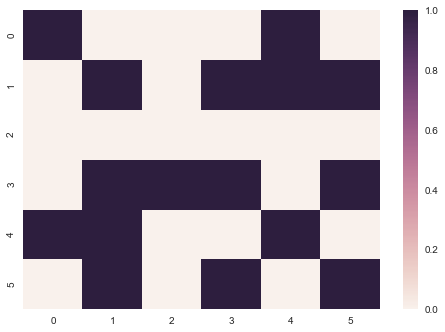

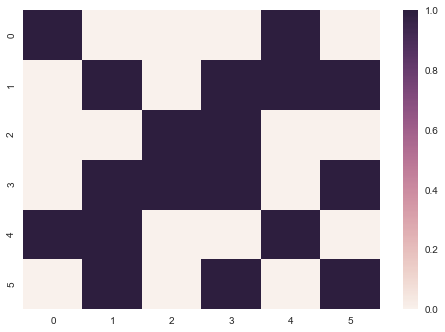

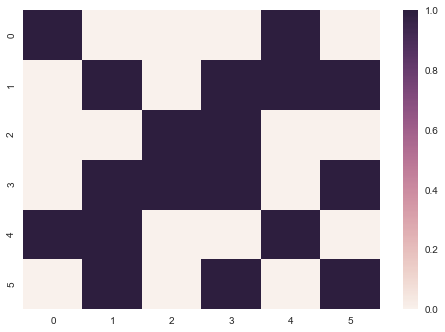

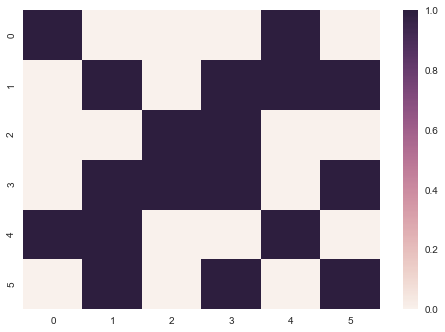

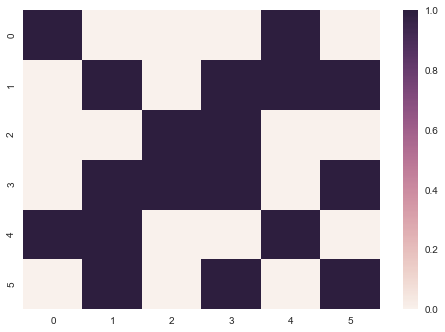

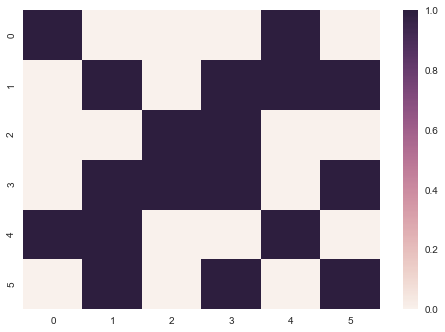

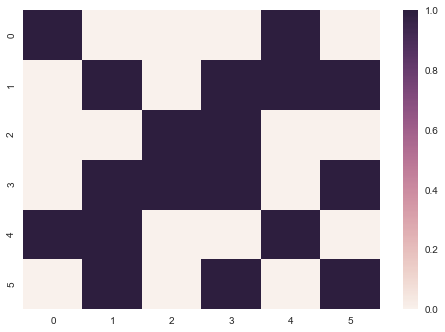

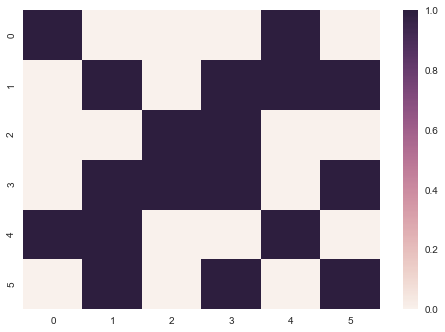

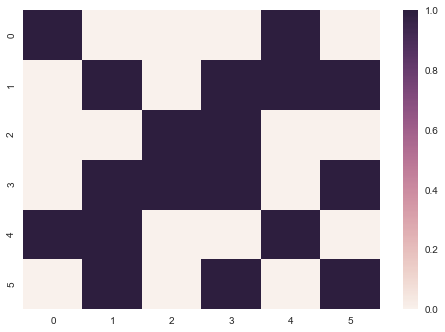

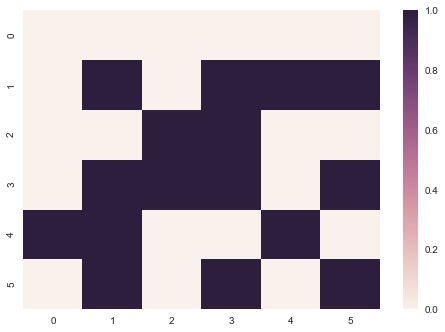

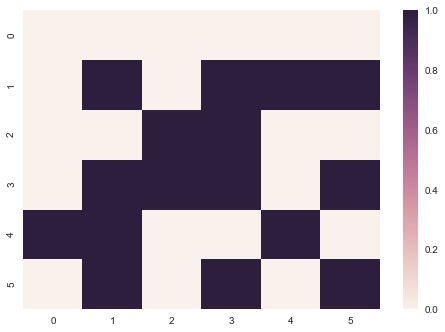

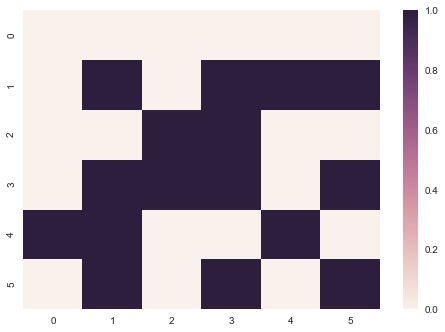

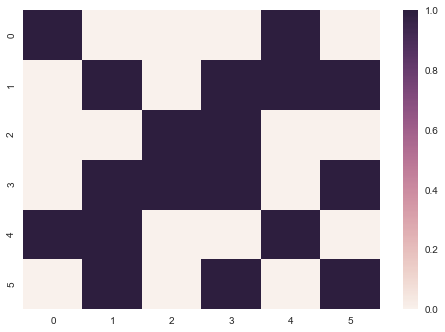

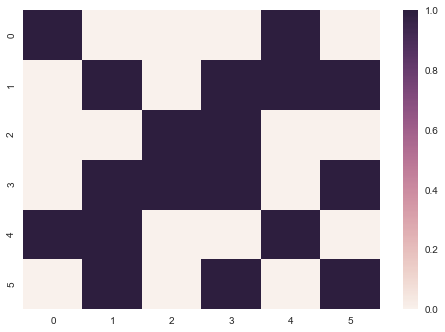

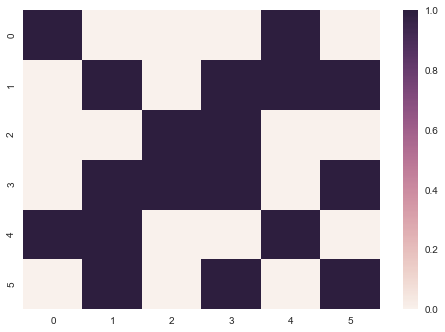

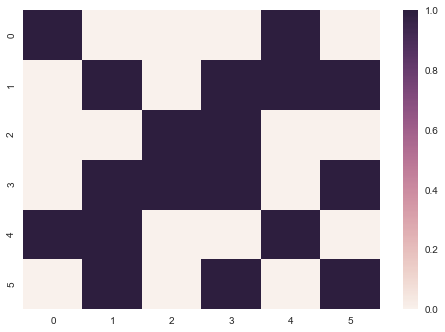

In [580]:
for t in range(24):
    sns.heatmap(omega(t))
    show()

In [568]:
from src.Ensemble import RoomModel, DeviceGenerator, FastAbstractEnsemble, eiv
from src.predefined import default_controls as controls
from src.predefined import environment_temp, q, default_preference_profile

from sklearn.linear_model import Ridge

In [569]:
random_seed = 42
m = 6
N = 3
n = 300
tau = 3

In [570]:
model = RoomModel(environment_temp, controls, q=q, tau=tau, user_profile=default_preference_profile)

In [571]:
generator = DeviceGenerator(random_seed=random_seed, room_model=model)

In [572]:
ensemble = FastAbstractEnsemble(n, N, m, generator)

In [573]:
avg_cons = array([model.tau*q.dot(eiv(control)) for control in controls])
u = array([eiv(control) for control in controls])
default_control_dist = array([n/m]*m)
default_pi = 1/n*array([Nj*uj for Nj, uj in zip(default_control_dist, u)]).sum(axis=0)
approx_cons = []
datasets = [pd.DataFrame(columns=["c%d"%d for d in range(m)] + ['s']) for _ in range(24)]
train = ["c0", "c1", "c2", "c3", "c4", "c5"]
test = ["s"]
consumption_predictions = []
real_consumptions = []
classifiers = {}

pi = default_pi

In [574]:
from scipy.optimize import minimize

def learn_regression(X, y):
    m = X.shape[1]
    f = lambda w: np.linalg.norm(X.dot(w) - y)**2
    jac = lambda w: 2*X.T.dot(X.dot(w) - y)
    cons = {'type' : 'eq', 'fun' : lambda x: sum(x) - n}
    bounds = tuple([(0, None) for _ in range(m)])
    res = minimize(f, np.zeros(m).reshape(-1, 1), constraints=cons, bounds=bounds)
    return res.x

In [575]:
for t in tqdm(range(24*10)):
    features = [sum([q.T.dot(np.linalg.matrix_power(control.T, i).dot(pi)) for i in range(1, tau+1)])
                for control in controls]
    w_prev = classifiers.get(t%24)
    if w_prev is None:
        w_prev = default_control_dist
        
    predicted_consumption = w_prev.dot(features)
    consumption_predictions.append(predicted_consumption)
    ensemble.run(0)
    real_consumption = ensemble.log["total_consumption"][-1]
    real_consumptions.append(real_consumption)
    datasets[t%24].loc[len(datasets[t%24])] = features + [real_consumption]
    w_new = learn_regression(np.array(datasets[t%24][train]), np.array(datasets[t%24][test]))    
    classifiers[t%24] = w_new
    pi = 1/n*array([N_j*matrix_power(P_j.T, tau).dot(pi) 
                    for N_j, P_j in zip(w_new, controls)]).sum(axis=0)

100%|██████████| 240/240 [00:55<00:00,  4.30it/s]


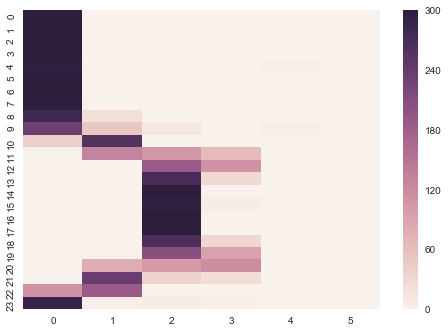

In [576]:
sns.heatmap(array([x for x in classifiers.values()]))

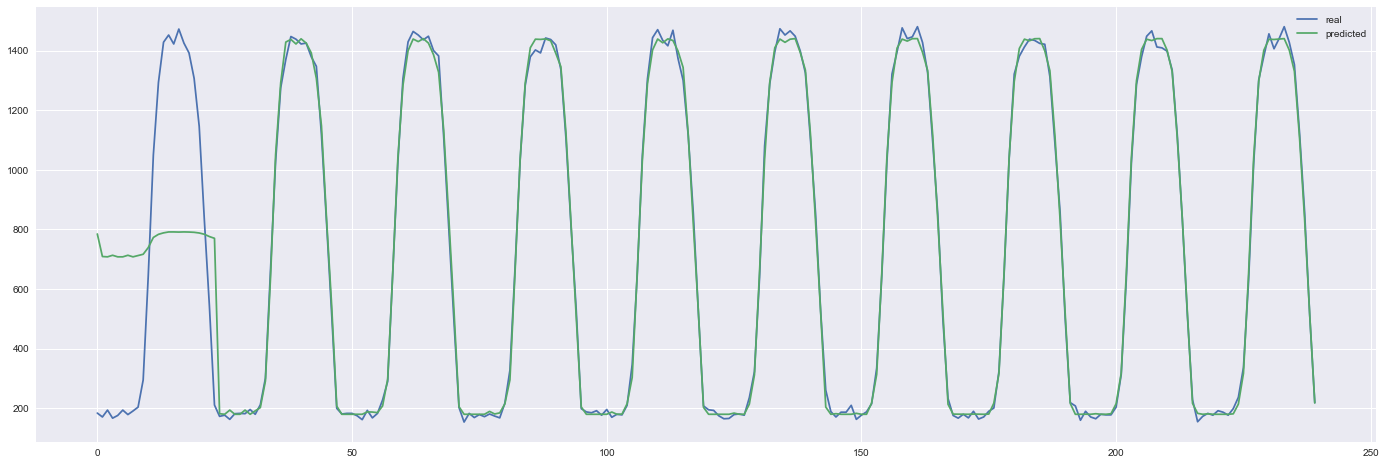

In [577]:
figure(figsize=(24, 8))
plot(real_consumptions, label="real")
plot(consumption_predictions, label="predicted")
legend()
show()

In [354]:
datasets[10]

,c0,c1,c2,c3,c4,c5,s
0,0.536667,0.536667,0.536667,0.536667,0.536667,0.536667,138.0
1,0.581532,0.581532,0.581532,0.581532,0.581532,0.581532,157.0
2,0.753766,0.753766,0.753766,0.753766,0.753766,0.753766,146.0
3,0.701793,0.701793,0.701793,0.701793,0.701793,0.701793,171.0
4,0.672839,0.672839,0.672839,0.672839,0.672839,0.672839,167.0
5,0.664062,0.664062,0.664062,0.664062,0.664062,0.664062,149.0
6,0.680245,0.680245,0.680245,0.680245,0.680245,0.680245,153.0
7,0.646390,0.646390,0.646390,0.646390,0.646390,0.646390,166.0
8,0.645571,0.645571,0.645571,0.645571,0.645571,0.645571,161.0
9,0.681784,0.681784,0.681784,0.681784,0.681784,0.681784,155.0


In [356]:
classifiers[10].coef_

array([[37.04055897, 37.04055897, 37.04055897, 37.04055897, 37.04055897,
        37.04055897]])

In [322]:
X = array([3.422283,  3.050945,  2.764606,  2.852462,  3.169498,  2.915573]).reshape(1, -1)
Y = array([272.0])
alg = Ridge(fit_intercept=False)
alg.fit(X, Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [323]:
alg.coef_

array([16.52039906, 14.72783779, 13.3455925 , 13.76970009, 15.30012912,
       14.07435605])

In [150]:
alg.fit(datasets[0][train], datasets[0][test])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [151]:
alg.coef_

array([[0., 0., 0., 0., 0., 0.]])

In [143]:
control = controls[3]
[q.T.dot(np.linalg.matrix_power(control, i).dot(pi)) for i in range(1, tau+10)]

[0.9235564304461945,
 0.9582611548556432,
 0.9706440288713913,
 0.9721503280839896,
 0.9712317896981628,
 0.9705691701115486,
 0.9703618630003281,
 0.9703476630889107,
 0.9703685495932168,
 0.9703809098334112,
 0.9703842702754271,
 0.9703842818640087]

In [136]:
[q.T.dot(np.linalg.matrix_power(control, i).dot(pi)) for i in range(1, tau+1)]

[1.0169816272965881, 1.0169816272965884, 1.0169816272965884]

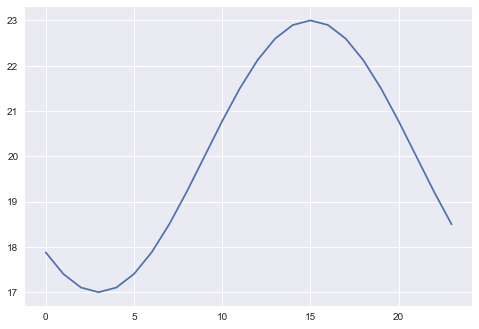

In [566]:
plot([environment_temp(t) for t in range(24)])

In [120]:
a = [[0]]*24
a[0][0] = 1
a

[[1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1]]

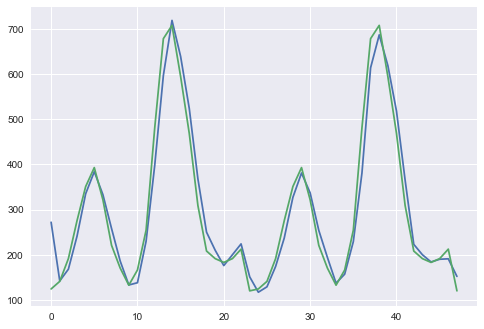

In [101]:
plot(ensemble.log["total_consumption"])
plot(approx_cons)